# Sentiment analysis in Python

We are working with different methods to analyze our dataset: 'amazon-fine-food-reviews', which is a dataset with reviews from amazon food products with scores from  zero stars to five stars. Those methods are: 
<u>
    <li> VADER (Valance Aware Dictionary sEntiment Reasoner) </li>
    <li> Roberta </li>
    <li> Hugging Pipline </li>
</u>

In [1]:
# Import some packages we are going to use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style of plots
plt.style.use('ggplot')

# Principal tool we will use to NLP.
import nltk

In [2]:
# First of all we read the dataset
df = pd.read_csv('C:/Users/bufal/Desktop/GitHub/Datasets/amazon_fine_food_reviews/Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [5]:
print(df.shape)

(568454, 10)


In [6]:
# Due to the amount of inputs and to reduce the executing time
# we select only the first 500 rows.

df = df.head(500)
print(df.shape)

(500, 10)


**Quick EDA**

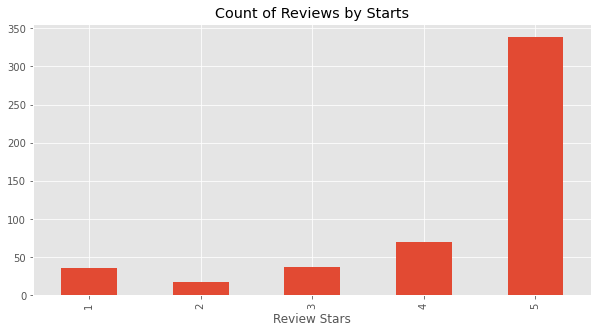

In [7]:
# We count the total number of different scores
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar', 
                                             title = 'Count of Reviews by Starts',
                                             figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

**Basic NLTK**

In [8]:
# Take a random review as example, here we can anticipate that the sentiment
# analysis should show not a good impresion.

example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [9]:
# Separate the review in tokens and select only few of them to exemplify

#nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [10]:
# We assign a default label for each type of word to our tokens.
# can consult the meaning in: 
# https://www.guru99.com/pos-tagging-chunking-nltk.html

#nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [11]:
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1: VADER Sentiment Scoring

We will use NLTK's 'SentimentIntensityAnalyzer' to get the neg/neu/pos scores of the text.


<ul> This uses a "bag of words" approach: 
    <li> Stop words are removed. </li>
    <li> Each word is scored and combined to a total score. </li>
</ul>

Is important to note that VADER doesn't get in ocunt the realtionships between words, which means that could label a message as neg instead of pos due to the singular clasification of words as tokens.

In [12]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# This package is a visual package to see the progress in osme process
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bufal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
# see how 'sia' is a vader sentiment item
sia

In [14]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [15]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [16]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [17]:
# Run the polaity score on the entire dataset
res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
# Visualize the results
vaders = pd.DataFrame(res).T
print(vaders)

       neg    neu    pos  compound
1    0.000  0.695  0.305    0.9441
2    0.138  0.862  0.000   -0.5664
3    0.091  0.754  0.155    0.8265
4    0.000  1.000  0.000    0.0000
5    0.000  0.552  0.448    0.9468
..     ...    ...    ...       ...
496  0.000  0.554  0.446    0.9725
497  0.059  0.799  0.142    0.7833
498  0.025  0.762  0.212    0.9848
499  0.041  0.904  0.055    0.1280
500  0.000  0.678  0.322    0.9811

[500 rows x 4 columns]


In [19]:
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')

In [20]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Plot VADER results**

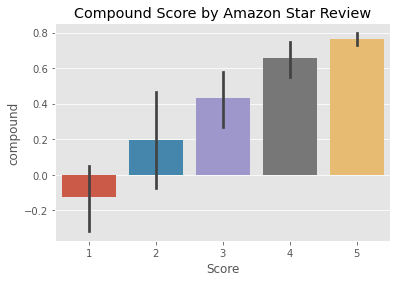

In [21]:
ax = sns.barplot(data = vaders, x= 'Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

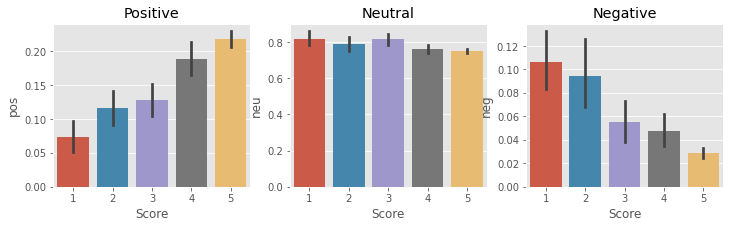

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data = vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data = vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data = vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
#plt.tight_layout()
plt.show()

## Step 2: Roberta Pretrained Model

<ul>
    <li> Use a model trained of a large corpus of data </li>
    <li>  Transformer model accounts for the words but also the context related to other words.</li>
</ul>

In [23]:
# Differents models could need different tokienizers, so we import an standar tokenizer 
# for roBERTa model throught AutoTokenizer function
from transformers import AutoTokenizer

# Different pre-trained models are optimizer to different NLP tasks and need different
# arquitectures and settings
from transformers import AutoModelForSequenceClassification

# Usually use in NLP problems to transform the output layer into a prob distribution
# Its like normalize the output of a neural network 
from scipy.special import softmax

In [24]:
# We make sure that there is no directory with the same name to avoid problems
# This step is really important !

import shutil
import os

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
if os.path.isdir(MODEL):
    shutil.rmtree(MODEL)
    print(f"El directorio '{MODEL}' ha sido eliminado correctamente.")
else:
    print(f"No se encontró un directorio con el nombre '{MODEL}'.")

El directorio 'cardiffnlp/twitter-roberta-base-sentiment' ha sido eliminado correctamente.


In [25]:
# We import roBERta model 
# pip install torch
import torch

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [26]:
# Run for Roberta Model
# ROBERTA = Robustly Optimized BERT Pretraining Approach
# BERT = Bidirectional Encoder Representations from Transformers
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

print(scores_dict)
# It returns an array with [negative, neutral, positive] scores

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573694}


In [27]:
# Define a funciton to simplify the obtention of results

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
        }
    return scores_dict

In [28]:
# Run the roberta polaity score on the entire dataset
# After a first run we observate that at some point around 16% it merges an error, so 
# we include and 'except' to solve it. It is due to some corrumption on dataset
res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        
        roberta_result = polarity_scores_roberta(text)
        roberta_result_rename = {}
        for key, value in roberta_result.items():
            roberta_result_rename[f"roberta_{key}"] = value
            
        # We combine both dictionaries
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

broke for id 83
broke for id 187


In [30]:
both

{'vader_neg': 0.0,
 'vader_neu': 0.678,
 'vader_pos': 0.322,
 'vader_compound': 0.9811,
 'roberta_neg': 0.0024397594,
 'roberta_neu': 0.011327226,
 'roberta_pos': 0.986233}

## Step 3: Compare Scores between models

In [39]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index' : 'Id'})
results_df = results_df.merge(df, how = 'left')

In [40]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [41]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

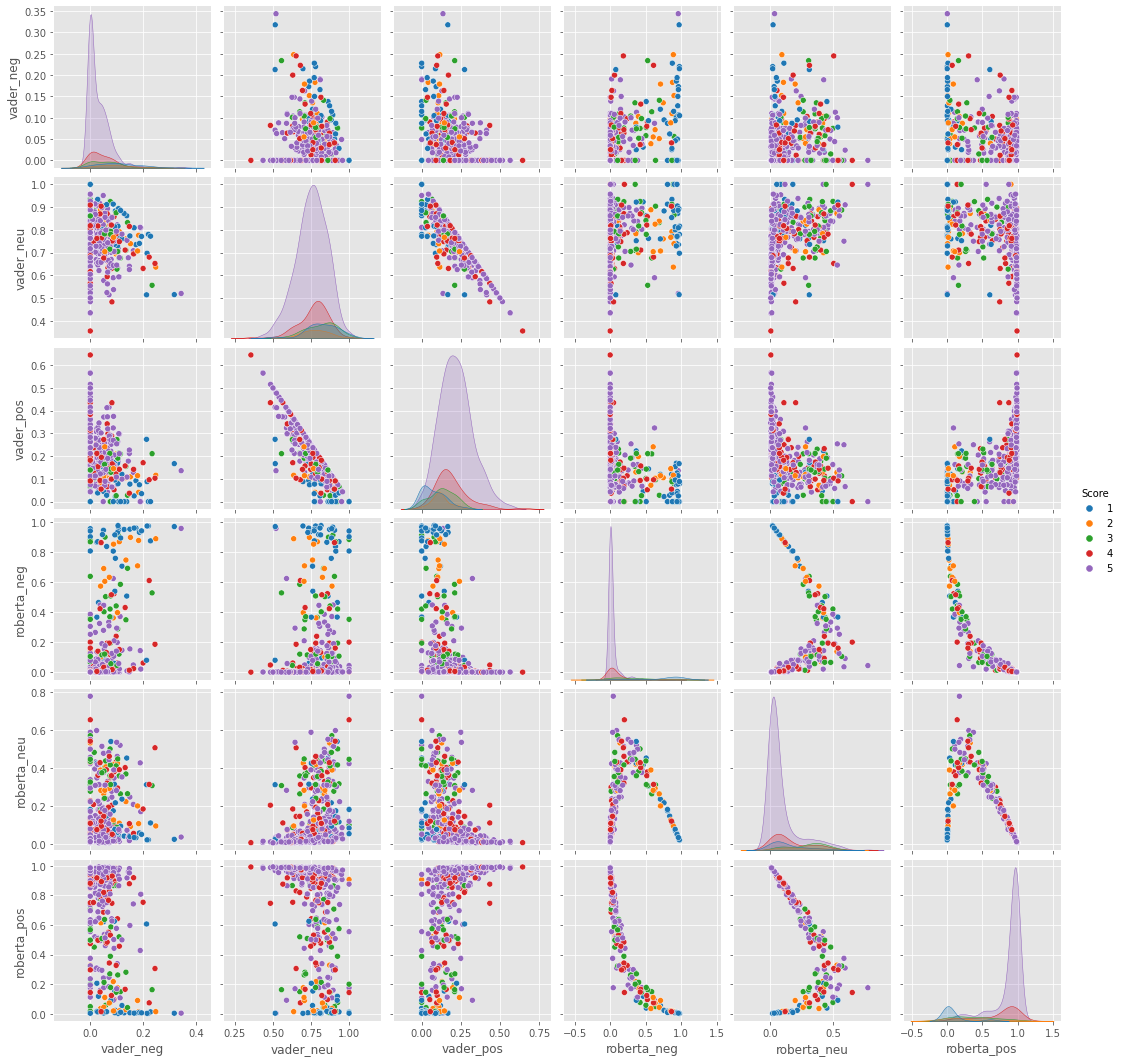

In [46]:
# Plot the correlations through pairplot() function.
# It returns a matrix 

sns.pairplot(data = results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = 'Score',
             palette = 'tab10')
plt.show()

## Step 4: Review Examples:

<ul>
    <li> Positive 1-Star and Negative 5-Star Reviews </li>
</ul>

Lets look at some examples where the model scoring and review score differ the most

In [49]:
# We take the most positive comment among the worst score posible.

results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [50]:
# We repeat the process but with the roBERTa model

results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [52]:
# Negative sentiment 5-star review for roBERta model

results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [54]:
# Negative sentiment 5-star review for VADER model

results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Extra: The transformers Pipeline

<ul>
    <li> Quick and easy way to run sentiment predictions  </li>
</ul>

In [55]:
from transformers import pipeline

In [57]:
sent_pipeline = pipeline("sentiment-analysis")
sent_pipeline('I am so happy!')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


C:\Users\bufal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bufal\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


[{'label': 'POSITIVE', 'score': 0.9998733997344971}]